# Assignment 6
Rename this Assignment and add your Group Number. Open this notebook in Jupyter Notebook, NOT Jupyter Lab! Otherwise images can not be inserted and will not load properly.

## Designing support models for the Bystander Effect


When a group of people notice someone is in some kind of trouble, often none of the bystanders offer any form of assistance. This is called the bystander effect. Figure 1 below shows a very simplified domain model about this phenomenon based on Latané and Darley (1970). Here, providing assistance is dependent on feeling the responsibility to help and interpreting the situation as being an emergency. Both factors are affected by the number of bystanders. Furthermore, being able to help affects the degree of responsibility and observing the situation affects the interpretation of the situation.

We have already constructed the following domain model of a bystander’s behaviour for you:

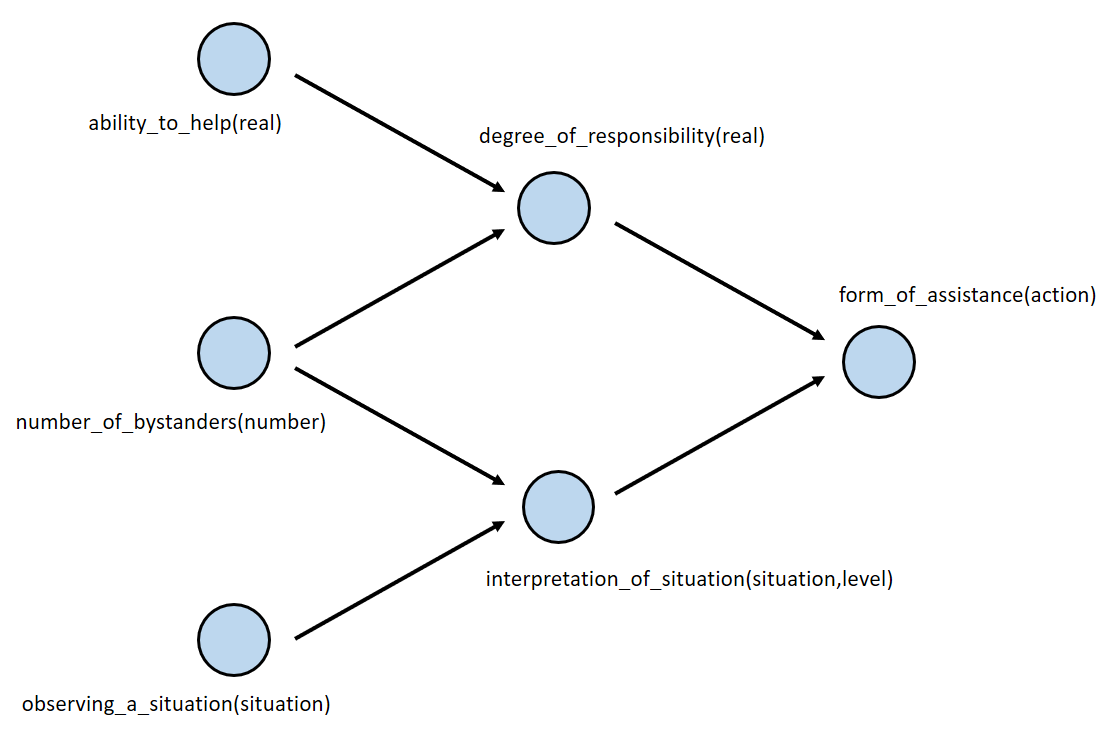

**Figure 1**. Graphical notation of the bystander effect domain model.

The predicates and sorts used in Figure 1 are formalised below in Table 1 and 2.

**Table 1**. Formalization of predicates for the bystander model

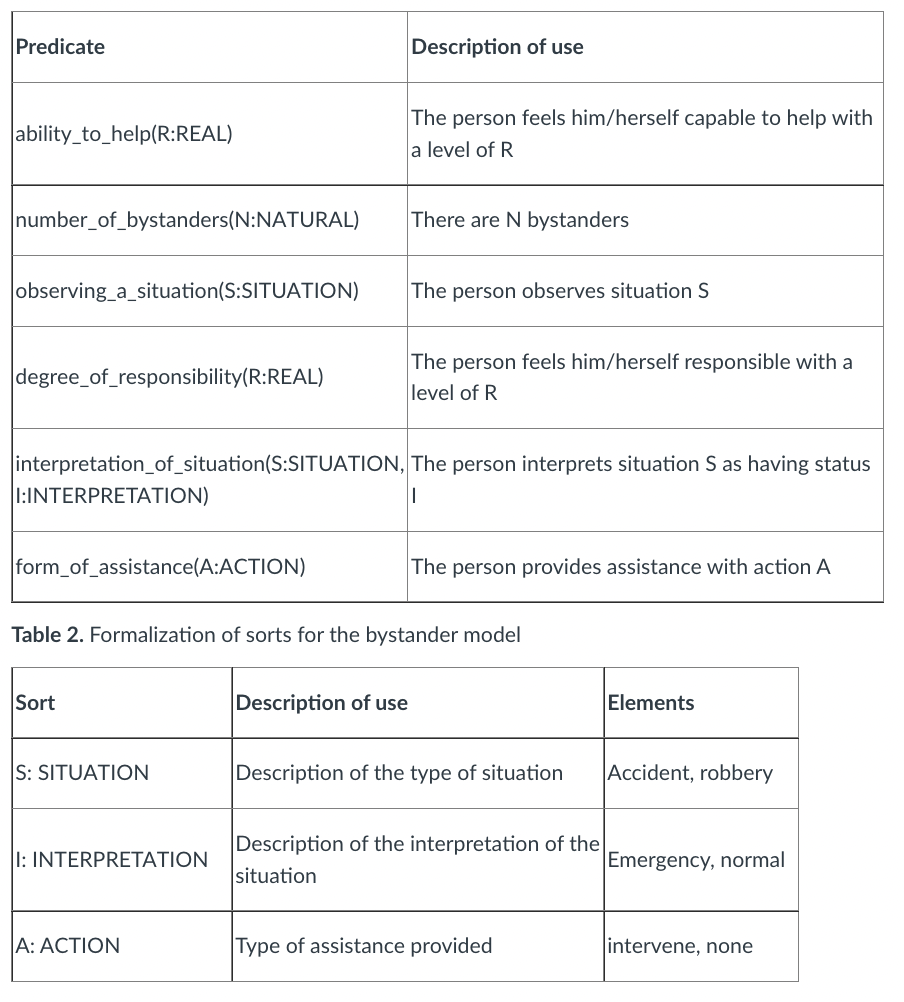

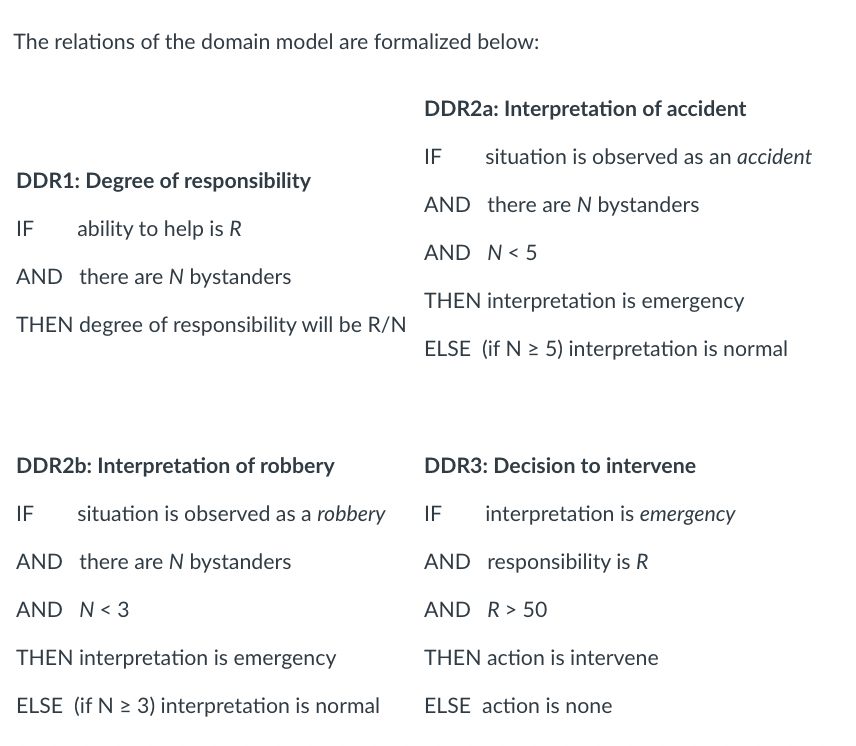


In order to trigger bystanders to intervene in dangerous situations, a system is developed that uses the domain model above as basis for an analysis and support model. An example of such a system could be an application on your smartphone that is linked to security cameras in the city. Using these cameras, the system can *observe* the *number of bystanders* in a situation. Based on this information, in certain cases the system will make the *assessment* that a particular bystander’s form of assistance will be ‘none’ (i.e., that the person will not provide help). As the *desire* of the system is that people will intervene, the system will provide support by sending a message to the bystander(s) in order to alert them of the seriousness of the situation; the aim of this message is to change their *interpretation of the situation* and see it as an emergency. This will hopefully lead to people intervening in the situation. However, this is not guaranteed to solve the situation, as the actual decision to intervene also depends on the perceived degree of responsibility. 

Given this description of the working of the system, you are asked to create the support model that this system uses. It should decide whether sending a message is appropriate.

### Extended domain model
1. First, extend the domain model with the support action. Create a graphical representation of this extended model (10 points).

***
<img src="extended_model.png" style="width:700px;height:500px;">
***

### Backward support model
2. Create a graphical representation of the support model, using backward reasoning. Start by adding the desire of the system as a concept. Then, adapt the model and the predicates to generate a support model that eventually proposes an action (25 points).

***
<img src="backward_support.png" style="width:700px;height:500px;">
***

### Forward support model
3. Create a graphical representation of the support model, using forward reasoning. Start by adding an assumption of the action of the system as a concept. Then, adapt the model and the predicates to generate a support model that eventually proposes an action (25 points).


***
<img src="forward_support.png" style="width:700px;height:500px;">
***

### Implementation
4. Implement the forward reasoning model L3-Python. Provide a scenario that results in a simulation that shows how the system reasons that the action "sending a message" will be proposed. (40 points)

A number of concepts are not calculated via rules, but defined in the scenario file. Those are:
* assumptions
* desires 
* belief about the *degree_of_responsibility*

Extend the scenario file with the appropriate desire, belief and assumption. For the first 15 time steps, the assumption about the support action should be false, during the remaining timesteps, it should be true. The responsibility can have a value between 1 and 10. You have to add four lines. 

In [2]:
%%writefile scenario_ass6.txt
assume{sending_a_message{false}}; [1:14]
assume{sending_a_message{true}}; [15:30]
desire{form_of_assistance{intervene}}; [1:Inf]
belief{degree_of_responsibility{6}}; [1:Inf]
belief{sending_a_message{false}}; [1]


Overwriting scenario_ass6.txt


In [3]:
from state import Predicate

#######################################
# any variables declared here will be treated as scenario parameters
ACCIDENT_THRESHOLD = 5
ROBBERY_THRESHOLD = 3
THRESHOLD_RESPONSIBILITY = 5

Create a rule that turns an assumption into a belief:

In [4]:
def set_belief_sending_a_message(states, t):
    """
        assume : {sending_a_message : [None, [Bool]]}
        belief : {sending_a_message : [None, [Bool]]}

    """

    previous_state = states[t - 1]
    new_predicates = []

    
    for predicate in previous_state.get_nested_predicate("assume", "sending_a_message"):
        new_predicates.append(Predicate(None, [predicate.value[0]]))
    states[t].add_nested_predicate_to_state("belief", "sending_a_message", new_predicates)

Create a rule that creates a belief about how people interpret the situation. The relevant situation is an "accident" and depending on the beliefs, it should either be "normal" or "emergency". 

In [5]:
def set_belief_interpretation_situation(states, t):
    """
        set the belief of the interpretation of the situation, based on whether a message was sent or not

        belief : {sending_a_message{[None, [Bool]]}}
        belief : {interpretation_of_situation{[None, [observation, interpretation]]}}

    """

    previous_state = states[t - 1]
    new_predicates = []

    for belief_sending_a_message in previous_state.get_nested_predicate("belief", "sending_a_message"):
        if belief_sending_a_message.value[0] == "true":
            interpretation = ["accident", "emergency"]
        else:
            interpretation = ["accident", "normal"]
        new_predicates.append(Predicate(None, interpretation))
    states[t].add_nested_predicate_to_state("belief", "interpretation_of_situation", new_predicates)


Now, based on the belief about the interpretation of the situation **and** the belief about *degree_of_responsibility*, we will generate a belief about the action that will be taken (*form of assistance*). The actions can be "intervene" or "none".  Use the parameter THRESHOLD_RESPONSIBILITY to determine whether it the degree of responsibility is sufficiently high. 

In [6]:
def set_belief_form_of_assistance(states, t):
    """
        set the belief of the form of assistance, based on the belief about the interpretation of the situation

        belief : {degree_of_responsibility{[None, [value]]}}
        belief : {interpretation_of_situation{[None, [observation, interpretation]]}}
        belief : {form_of_assistance{[None, [action]]}}

    """

    previous_state = states[t - 1]
    new_predicates = []
    if previous_state.check_belief_in_beliefs("interpretation_of_situation") and \
        previous_state.check_belief_in_beliefs("degree_of_responsibility"):
        for belief_interpretation in previous_state.get_nested_predicate("belief", "interpretation_of_situation"):
            interpretation = belief_interpretation.value
        for belief_responsibility in previous_state.get_nested_predicate("belief", "degree_of_responsibility"):
            responsibility = belief_responsibility.value[0]
            if interpretation[1] == "emergency" and responsibility > THRESHOLD_RESPONSIBILITY:
                action = "intervene"
            else:
                action = "none"
        new_predicates.append(Predicate(None, [action]))
    states[t].add_nested_predicate_to_state("belief", "form_of_assistance", new_predicates)

The final rule combines the desires, assumptions and beliefs to generate whether the support action should be proposed. The rule is already complete, you only have to rename it to use the right predicates.

In [7]:
def set_propose_ACTION(states, t):
    """
        assume : {sending_a_message{[None, [Bool*]]}}
        belief : {form_of_assistance{[None, [action]]}}
        desire : {form_of_assistance{[None, [action]]}}
        propose : {sending_a_message{[None, [Bool]]}}
        Bool* = 'true' / 'false' instead of True / False

    """

    previous_state = states[t - 1]
    new_predicates = []
    if previous_state.check_belief_in_beliefs("form_of_assistance"):
        proposal, assumption, belief_form, desired_form = [-1, -1, -1, -1]
        for assume_sending_a_message in previous_state.get_nested_predicate("assume", "sending_a_message"):
            assumption = assume_sending_a_message.value[0]
        for belief_form_of_assistance in previous_state.get_nested_predicate("belief", "form_of_assistance"):
            belief_B = belief_form_of_assistance.value[0]
        for desire_form_of_assistance in previous_state.get_nested_predicate("desire", "form_of_assistance"):
            desired_C = desire_form_of_assistance.value[0]
        if assumption == 'true' and belief_B == "intervene" and desired_C == "intervene":
            proposal = True
        else:
            proposal = False
        new_predicates.append(Predicate(None, [proposal]))
    states[t].add_nested_predicate_to_state("propose", "ACTION_TO_PROPOSE", new_predicates)

In [8]:
###############################
# any functions that actually need to be executed in the simulation must be put in this list
rules = [set_belief_sending_a_message, set_belief_interpretation_situation,
         set_belief_form_of_assistance, set_propose_ACTION]

Now, run the model and show that the support action is proposed some time after time point 15 (when the assumption about the support action became true).

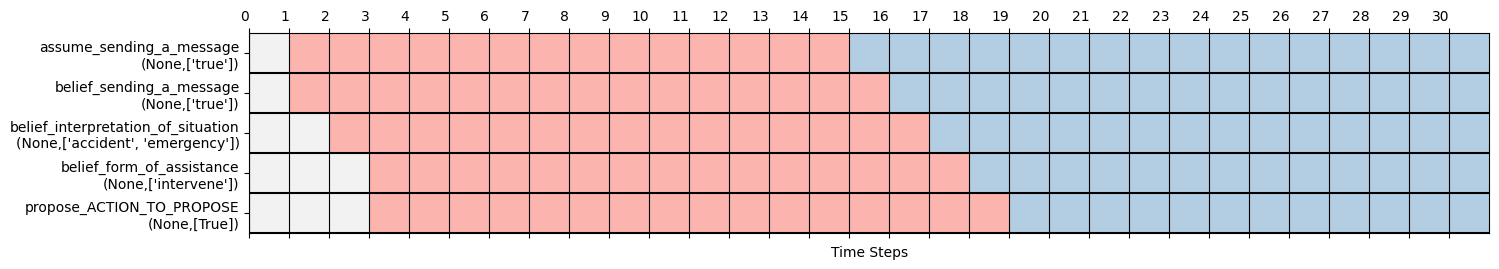

In [9]:
from state_machine import StateMachine
from visualization import run_visualization

MAX_T = 30
StateMachine = StateMachine("scenario_ass6.txt", MAX_T, rules, agents=False)

StateMachine.run()

run_visualization(StateMachine, 'bar', [("assume_sending_a_message", None, ['true']),
                                        ("belief_sending_a_message", None, ['true']),
                                        ("belief_interpretation_of_situation", None, ['accident', 'emergency']),
                                        ("belief_form_of_assistance", None, ['intervene']),
                                        ("propose_ACTION_TO_PROPOSE", None, [True])], MAX_T)